In [324]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from pyunicorn.timeseries import RecurrencePlot
import iberoSignalPro.preprocesa as ib
import ntwktools as nt

import logging
logging.basicConfig(level=logging.CRITICAL)

In [325]:
def rp_adquisition(file_path, bands = "mu",  channels = ["Cz", "C1", "C2"], norm = False, max_min = [0, 1], vecindad = 0, tau = 1, dim = 1, metric = "manhattan"):
    '''
    bands: mu, beta, gamma
    metric: manhattan, epsilon, supremum
    '''
    df = pd.read_csv(file_path)
    act, rep = nt.obtener_win(df.EnvAnta, df.Binaria, siPlot = False)
    act, rep = nt.selecciona_ventanas(act, rep, siPlot = True, signal = df.EnvAnta, win_len=15)
    
    band_signals = df[[f"{bands}_" + channel for channel in channels]]

    min_v = band_signals.min().min()
    max_v = band_signals.max().max()
    print(min_v, max_v)
    if norm:
        band_signals = ib.normaliza(band_signals, min_val= max_min[0], max_val= max_min[1]).T
        #band_signals = ib.normaliza(band_signals, options="morum").T
    activity_rps = []
    rest_rps = []
    for act_start, act_end in act:
        activity_signals = np.array(band_signals[act_start:act_end])
        if vecindad == 0:
            vecindad = activity_signals.std() * 1.2
        try:
            activity_rp = RecurrencePlot(activity_signals, threshold=vecindad, tau=tau, epsilon='distance', metric=metric)
            activity_rps.append(activity_rp)
        except Exception as e:
            print(f"error: {e}")

    for rep_start, rep_end in rep:
        rest_signals = np.array(band_signals[rep_start:rep_end])
        if vecindad == 0:
            vecindad = rest_signals.std() * 1.2
        try:
            rest_rp = RecurrencePlot(rest_signals, threshold=vecindad, tau=tau, epsilon='distance', metric=metric)
            rest_rps.append(rest_rp)
        except Exception as e:
            print(f"error: {e}")
    return activity_rps, rest_rps, [min_v, max_v]

In [326]:
selected_channels = [["C2", "C1", "Cz", "Pz"],
                     ["Cz", "Oz", "FCz", "P3"],
                     ["C3", "FC4", "CP3", "P4"]]

band = "gamma"
if band == "mu":
    selected_channels = selected_channels[0]
elif band == "beta":
    selected_channels = selected_channels[1]
else:
    selected_channels = selected_channels[2]

In [394]:
def read_csvs(folder_path, carga = 10, band = "mu", selected_channels = ["C2", "C1", "FCz", "Cz", "Pz"]):
    
    files = os.listdir(folder_path)
    csv_files = [file for file in files if file.endswith('.csv')]
    if not csv_files:
        print("No se encontraron archivos csv")
        return None, None, None
    
    
    for csv_file in csv_files:
        print(f"Reading {csv_file}")
        file_path = os.path.join(folder_path, csv_file)

        if carga == 10:
            target_csv = "10deTorquePre.csv"
        elif carga == 5:
            target_csv = "5deTorquePre.csv"
        elif carga == 0:
            target_csv = "pasivoPre.csv"

        if csv_file == target_csv:
            try:
                if band == "mu":
                    activity_rps, rest_rps, vals = rp_adquisition(file_path, bands = band,  channels=selected_channels, norm = True, max_min = [-0.0041, 0.79673], vecindad = 0.10, tau = 3, metric="manhattan")

                elif band == "beta":
                    activity_rps, rest_rps, vals = rp_adquisition(file_path, bands = band,  channels=selected_channels, norm = True, max_min = [-0.01737, 0.821], vecindad = 0.15, tau = 3, metric="manhattan")
                else:
                    activity_rps, rest_rps, vals= rp_adquisition(file_path, bands = band,  channels=selected_channels, norm = True, max_min = [-0.00926, 0.8103], vecindad = 0.2, tau = 3, metric="manhattan")
            except Exception as e:
                print("Error en 10")
                
    return activity_rps, rest_rps, vals


C:\Users\fercy\OneDrive\Escritorio\InternadoFMM\Pruebas%20BCI\SeñalesProcesadas10Hz2\AlejandoPayan\S1
Reading C:\Users\fercy\OneDrive\Escritorio\InternadoFMM\Pruebas%20BCI\SeñalesProcesadas10Hz2\AlejandoPayan\S1
Reading 10deTorquePre.csv
(2810,)
0.0149654358930449 0.4947746293640555
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Reading 5deTorquePre.csv
Reading pasivoPre.csv
C:\U

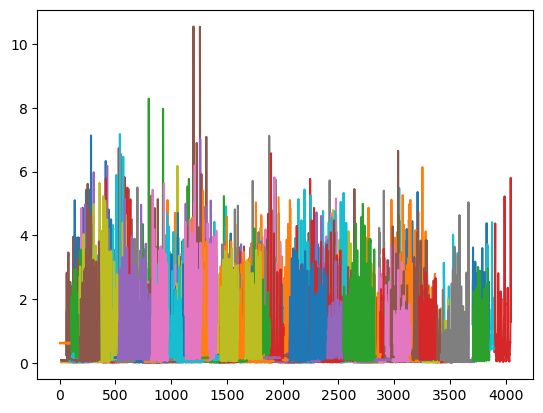

In [395]:
actividades = []
reposos = []
limites_v = []

root_folder_path = r"C:\Users\fercy\OneDrive\Escritorio\InternadoFMM\Pruebas%20BCI\SeñalesProcesadas10Hz2"

sub_sub_folders = []

items_in_root = os.listdir(root_folder_path)

sub_folders = [item for item in items_in_root if os.path.isdir(os.path.join(root_folder_path, item))]
for sub_folder in sub_folders:
    sub_folder_path = os.path.join(root_folder_path, sub_folder)
    items_in_sub_folder = os.listdir(sub_folder_path)
    for item in items_in_sub_folder:
        item_path = os.path.join(sub_folder_path, item)
        if os.path.isdir(item_path):
            print(item_path)
            sub_sub_folders.append(item_path)
            try:
                print(f"Reading {item_path}")
                
                activity, rest, vals = read_csvs(item_path, 10, band=band, selected_channels=selected_channels)
                if activity != None:

                    limites_v.append(vals)
                    actividades.append(activity)
                    reposos.append(rest)
                
                pass 
            except Exception as e:
                error_message = f"******************************** Error {e} en {item_path}\n"
                print(error_message)
            

In [396]:
actividades_flat = [item for sublist in actividades for item in sublist]
reposos_flat = [item for sublist in reposos for item in sublist]

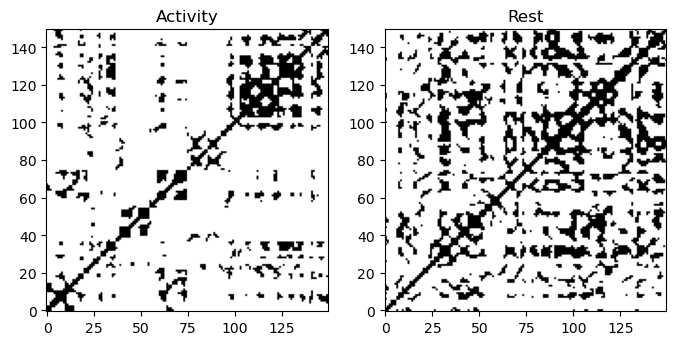

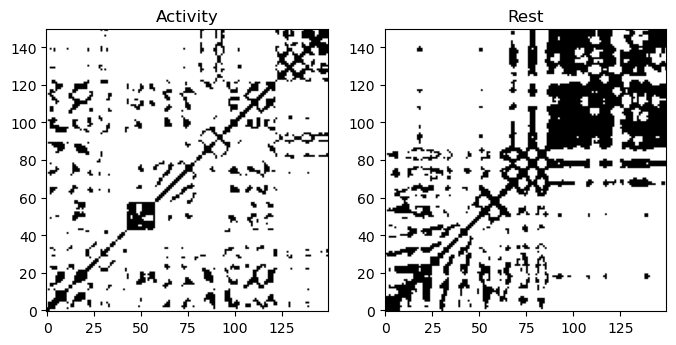

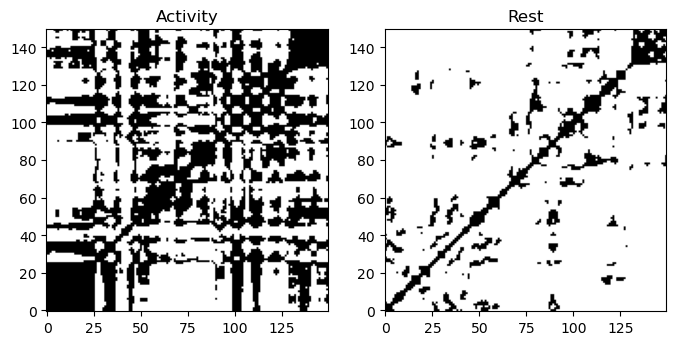

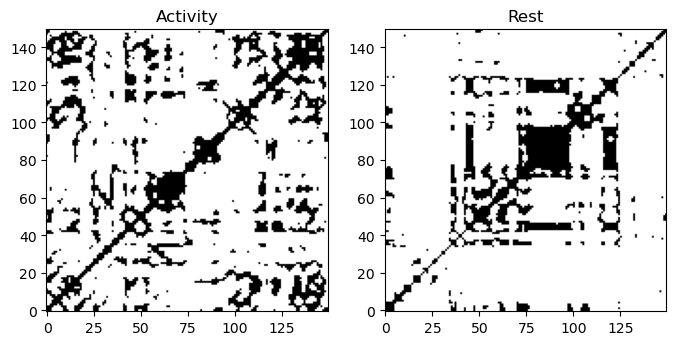

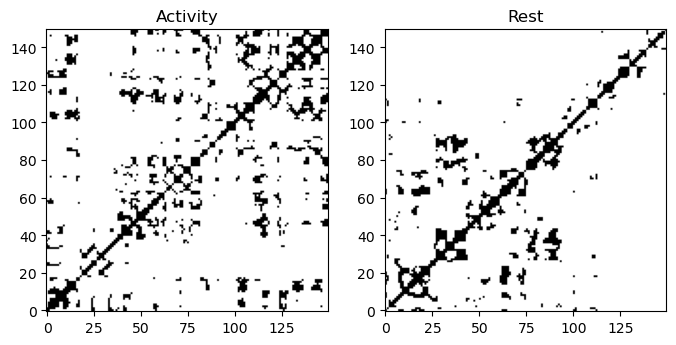

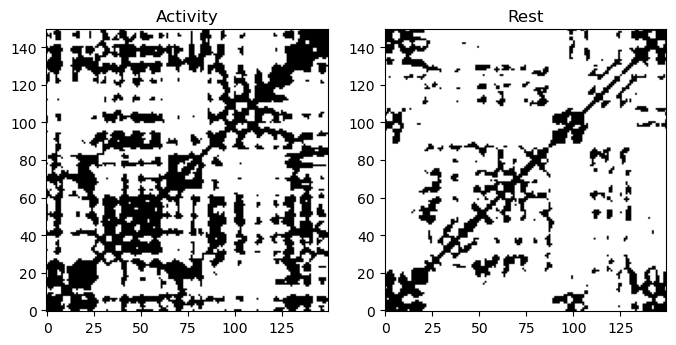

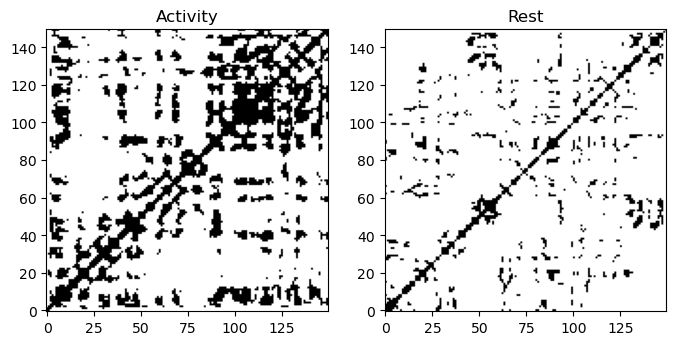

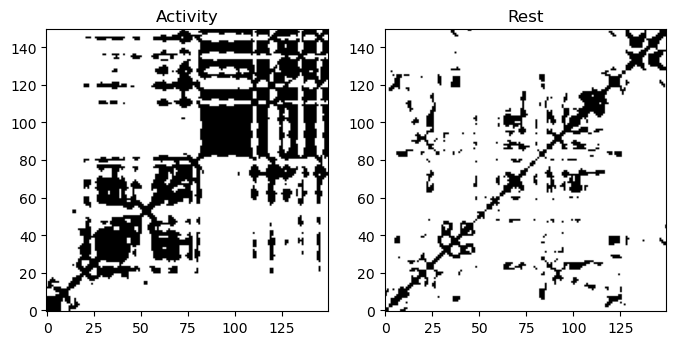

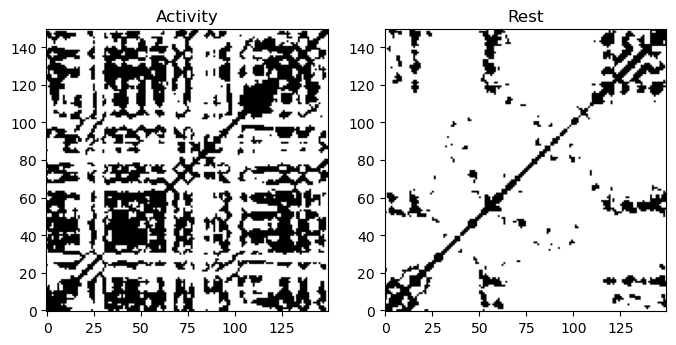

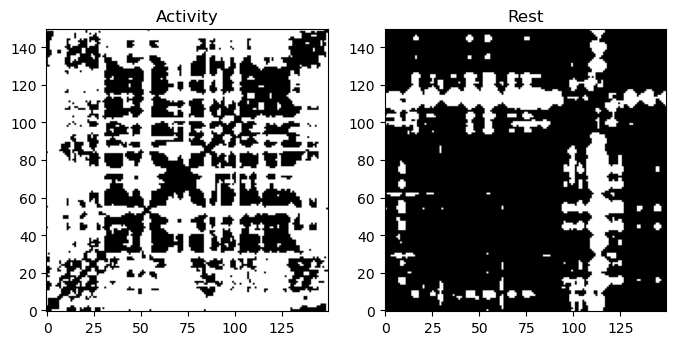

In [397]:
for i in range(0, min([len(actividades_flat), len(reposos_flat)]), 20):
    plt.figure(figsize= (8, 8))
    plt.subplot(1, 2, 1)

    plt.imshow(actividades_flat[i].recurrence_matrix(), cmap='binary', origin='lower')
    plt.title("Activity")
    plt.subplot(1, 2, 2)
    plt.imshow(reposos_flat[i].recurrence_matrix(), cmap='binary', origin='lower')
    plt.title("Rest")
    plt.show()

In [398]:
# Crear diccionario incluyendo todos los parámetros disponibles
dict_ = {
    "label": [],
    "recurrence_rate": [],
    "determinism": [],
    "laminarity": [],
    "trapping_time": [],
    "diag_entropy": [],
    "vert_entropy": [],
    "avg_diag_length": [],
    "average_vertlength": [],
    "average_white_vertlength": [],
    "max_diaglength": [],
    "max_vertlength": [],
    "max_white_vertlength": [],
    "mean_recurrence_time": [],
}

# Para las actividades
for rqa in actividades_flat:
    dict_["label"].append("Actividad")
    dict_["recurrence_rate"].append(rqa.recurrence_rate())
    dict_["determinism"].append(rqa.determinism())
    dict_["laminarity"].append(rqa.laminarity())
    dict_["trapping_time"].append(rqa.trapping_time())
    dict_["diag_entropy"].append(rqa.diag_entropy())
    dict_["vert_entropy"].append(rqa.vert_entropy())
    dict_["avg_diag_length"].append(rqa.average_diaglength())
    dict_["average_vertlength"].append(rqa.average_vertlength())
    dict_["average_white_vertlength"].append(rqa.average_white_vertlength())
    
    dict_["max_diaglength"].append(rqa.max_diaglength())
    dict_["max_vertlength"].append(rqa.max_vertlength())
    dict_["max_white_vertlength"].append(rqa.max_white_vertlength())
    dict_["mean_recurrence_time"].append(rqa.mean_recurrence_time())

# Para los reposos
for rqa in reposos_flat:
    dict_["label"].append("Reposo")
    dict_["recurrence_rate"].append(rqa.recurrence_rate())
    dict_["determinism"].append(rqa.determinism())
    dict_["laminarity"].append(rqa.laminarity())
    dict_["trapping_time"].append(rqa.trapping_time())
    dict_["diag_entropy"].append(rqa.diag_entropy())
    dict_["vert_entropy"].append(rqa.vert_entropy())
    dict_["avg_diag_length"].append(rqa.average_diaglength())
    dict_["average_vertlength"].append(rqa.average_vertlength())
    dict_["average_white_vertlength"].append(rqa.average_white_vertlength())
    dict_["max_diaglength"].append(rqa.max_diaglength())
    dict_["max_vertlength"].append(rqa.max_vertlength())
    dict_["max_white_vertlength"].append(rqa.max_white_vertlength())
    dict_["mean_recurrence_time"].append(rqa.mean_recurrence_time())

# Crear DataFrame
df = pd.DataFrame(dict_)
df.head()



,label,recurrence_rate,determinism,laminarity,trapping_time,diag_entropy,vert_entropy,avg_diag_length,average_vertlength,average_white_vertlength,max_diaglength,max_vertlength,max_white_vertlength,mean_recurrence_time
0,Actividad,0.134400,0.809325,0.920966,3.961593,1.516888,1.851631,3.461310,3.961593,18.270169,47,24,138,18.270169
1,Actividad,0.334489,0.880152,0.948180,5.021816,1.804018,2.165871,3.948905,5.021816,8.254686,104,33,96,8.254686
2,Actividad,0.399378,0.894975,0.954596,5.243276,1.883070,2.245559,4.188559,5.243276,6.716700,149,43,81,6.716700
3,Actividad,0.353244,0.894845,0.951686,4.830140,1.828027,2.152846,3.991991,4.830140,7.157895,149,46,119,7.157895
4,Actividad,0.113956,0.771334,0.899376,3.631496,1.472238,1.725919,3.385455,3.631496,19.355340,39,16,146,19.355340


In [399]:
#sns.pairplot(df, corner=True, hue = "label")

In [400]:
significant_cols, pvals = nt.get_significat_cols(df, p_val=0.01, label = "label", test="t_test")

In [401]:
significant_cols

['trapping_time',
 'diag_entropy',
 'vert_entropy',
 'avg_diag_length',
 'average_vertlength',
 'max_vertlength']

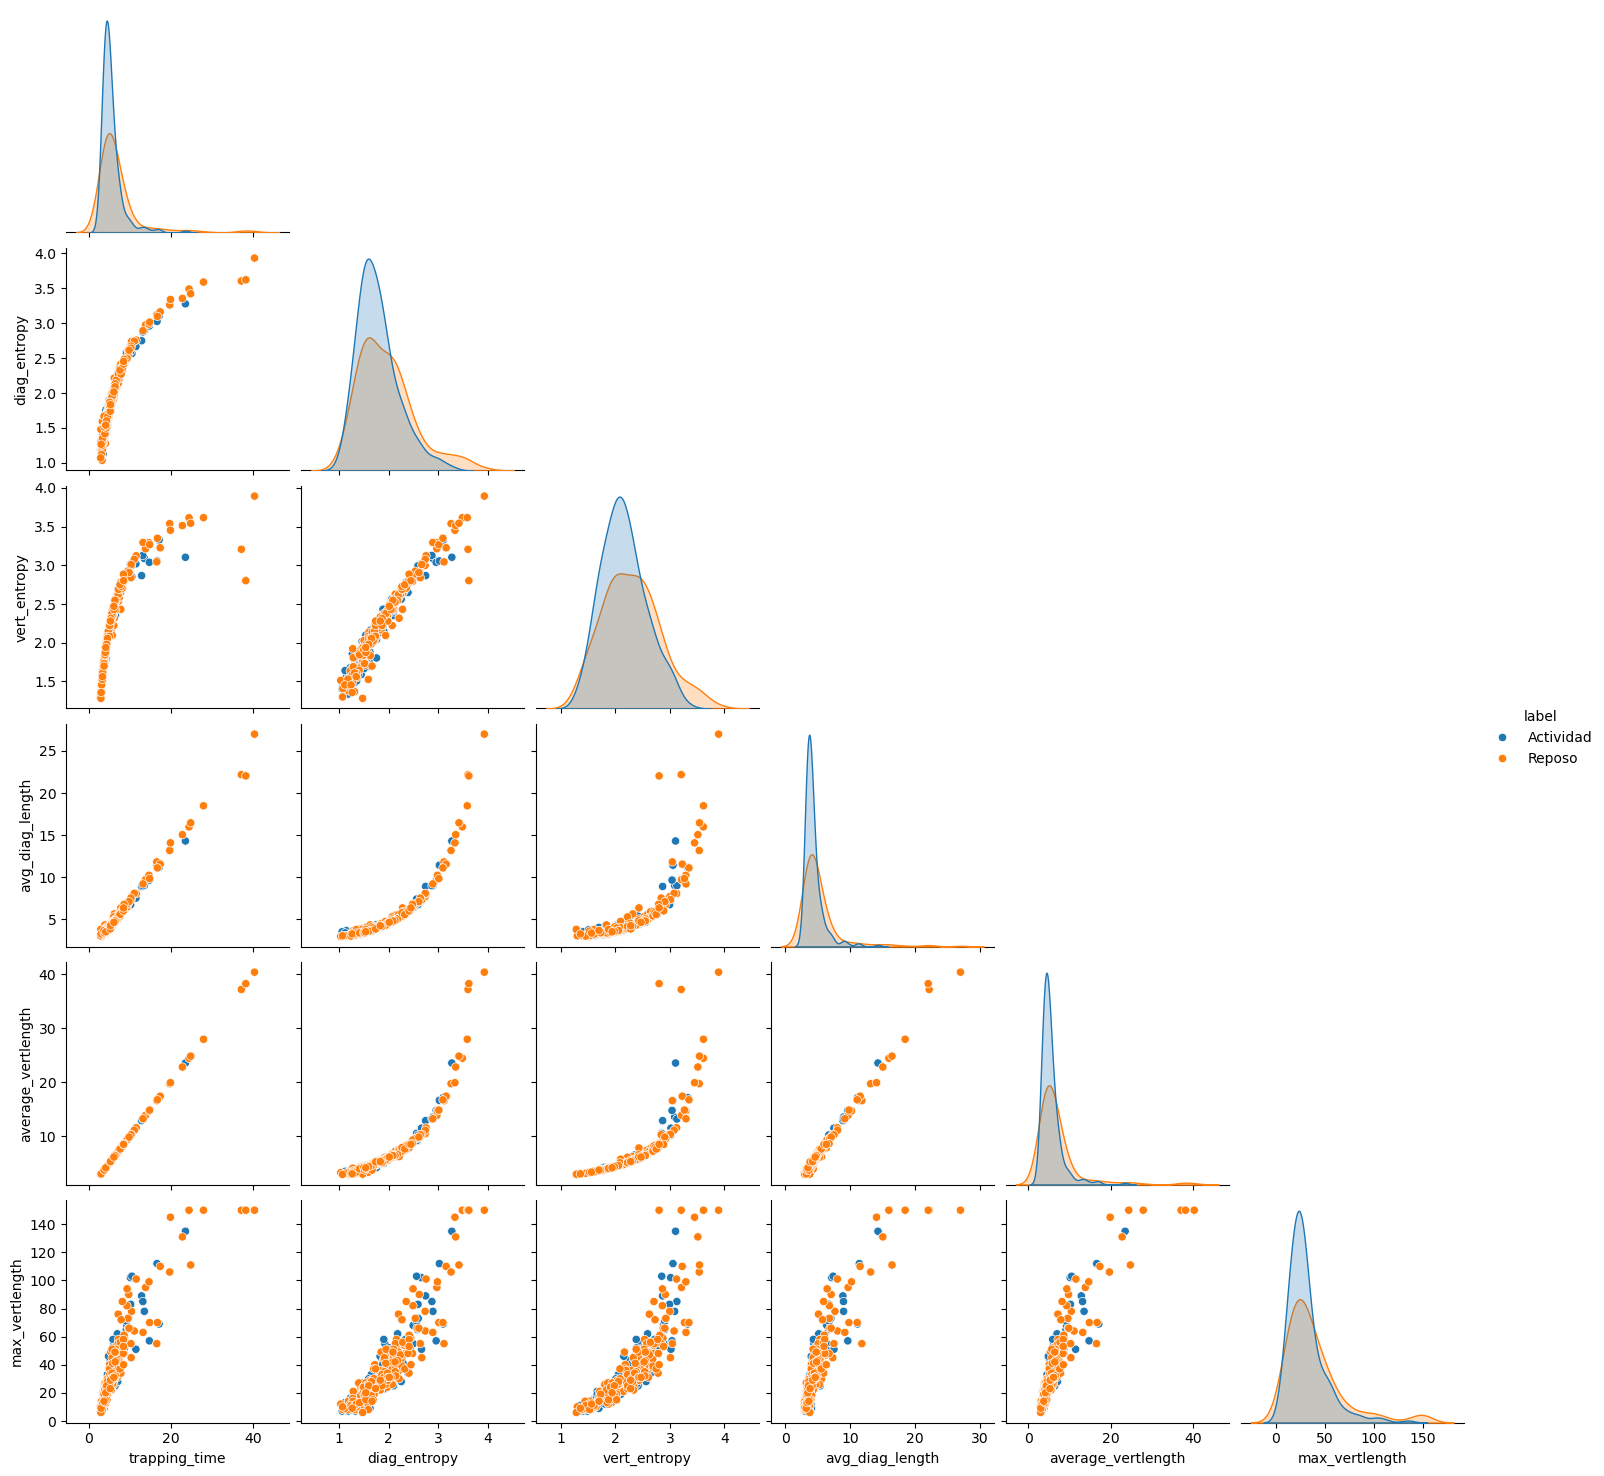

In [402]:
sns.pairplot(df[significant_cols + ["label"]], corner=True, hue="label")

In [403]:
def get_rp_carga(carga = 10, band = "mu", selected_channels = []):
    actividades = []
    reposos = []
    limites_v = []
    root_folder_path = r"C:\Users\fercy\OneDrive\Escritorio\InternadoFMM\Pruebas%20BCI\SeñalesProcesadas10Hz2"

    sub_sub_folders = []

    items_in_root = os.listdir(root_folder_path)

    sub_folders = [item for item in items_in_root if os.path.isdir(os.path.join(root_folder_path, item))]
    for sub_folder in sub_folders:
        sub_folder_path = os.path.join(root_folder_path, sub_folder)
        items_in_sub_folder = os.listdir(sub_folder_path)
        for item in items_in_sub_folder:
            item_path = os.path.join(sub_folder_path, item)
            if os.path.isdir(item_path):
                #print(item_path)
                sub_sub_folders.append(item_path)
                try:
                    
                    activity, rest, vals = read_csvs(item_path, carga, band=band, selected_channels=selected_channels)
                    if vals != None:
                        limites_v.append(vals)
                        actividades.append(activity)
                        reposos.append(rest)
                    
                    pass 
                except Exception as e:
                    error_message = f"******************************** Error {e} en {item_path}\n"
                    #print(error_message)

    actividades_flat = [item for sublist in actividades for item in sublist]
    reposos_flat = [item for sublist in reposos for item in sublist]
    return actividades_flat, reposos_flat, limites_v

Reading 10deTorquePre.csv
(2810,)
0.0149654358930449 0.4947746293640555
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Reading 5deTorquePre.csv
Reading pasivoPre.csv
Reading 10deTorquePre.csv
(2464,)
0.0158895218153127 0.6871691572129259
Calculating recurrence plot at fixed threshold...
Calculating the manhattan distance matrix...
Calculating recurrence plot at fixed threshold...

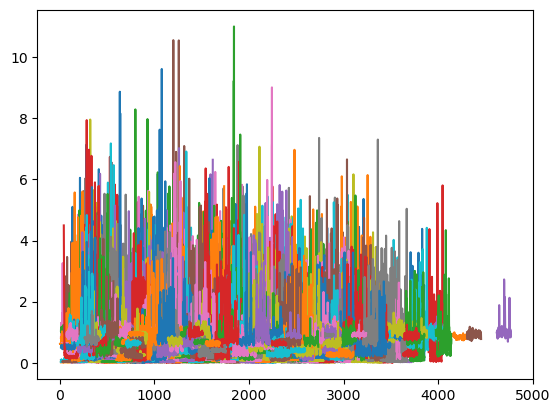

In [404]:
selected_channels = [["C2", "C1", "Cz", "Pz"],
                     ["Cz", "Oz", "FCz", "P3"],
                     ["C3", "FC4", "CP3", "P4"]]

band = "gamma"
if band == "mu":
    selected_channels = selected_channels[0]
elif band == "beta":
    selected_channels = selected_channels[1]
else:
    selected_channels = selected_channels[2]

actividad_10, reposo_10, vals10 = get_rp_carga(carga = 10, band=band, selected_channels=selected_channels)
actividad_5, reposo_5, vals5 = get_rp_carga(carga = 5, band=band, selected_channels=selected_channels)
actividad_0, reposo_0, vals0 = get_rp_carga(carga = 0, band=band, selected_channels=selected_channels)


In [405]:
vals10 = np.array(vals10)
print(np.min(vals10), np.max(vals10))
vals5 = np.array(vals5)
print(np.nanmin(vals5), np.nanmax(vals5))
vals0 = np.array(vals0)
print(np.nanmin(vals0), np.nanmax(vals0))

print(np.nanmin([np.nanmin(vals10), np.nanmin(vals5), np.nanmin(vals0)]), np.nanmax([np.nanmax(vals10), np.nanmax(vals5), np.nanmax(vals0)]))

0.0002382043472352 0.7766822137548945
-0.0092557142047084 0.8045700251283043
-0.0092120179836074 0.8103026100788949
-0.0092557142047084 0.8103026100788949


In [406]:

dict_ = {
    "label": [],
    "recurrence_rate": [],
    "determinism": [],
    "laminarity": [],
    "trapping_time": [],
    "diag_entropy": [],
    "vert_entropy": [],
    "avg_diag_length": [],
    "average_vertlength": [],
    "average_white_vertlength": [],
    "max_diaglength": [],
    "max_vertlength": [],
    "max_white_vertlength": [],
    "mean_recurrence_time": [],
}

In [407]:


# Para las actividades 10 de torque

for rqa in actividad_10:
    dict_["label"].append("SE10")
    dict_["recurrence_rate"].append(rqa.recurrence_rate())
    dict_["determinism"].append(rqa.determinism())
    dict_["laminarity"].append(rqa.laminarity())
    dict_["trapping_time"].append(rqa.trapping_time())
    dict_["diag_entropy"].append(rqa.diag_entropy())
    dict_["vert_entropy"].append(rqa.vert_entropy())
    dict_["avg_diag_length"].append(rqa.average_diaglength())
    dict_["average_vertlength"].append(rqa.average_vertlength())
    dict_["average_white_vertlength"].append(rqa.average_white_vertlength())
    dict_["max_diaglength"].append(rqa.max_diaglength())
    dict_["max_vertlength"].append(rqa.max_vertlength())
    dict_["max_white_vertlength"].append(rqa.max_white_vertlength())
    dict_["mean_recurrence_time"].append(rqa.mean_recurrence_time())

# Para las actividades 5 de torque

for rqa in actividad_5:
    dict_["label"].append("SE5")
    dict_["recurrence_rate"].append(rqa.recurrence_rate())
    dict_["determinism"].append(rqa.determinism())
    dict_["laminarity"].append(rqa.laminarity())
    dict_["trapping_time"].append(rqa.trapping_time())
    dict_["diag_entropy"].append(rqa.diag_entropy())
    dict_["vert_entropy"].append(rqa.vert_entropy())
    dict_["avg_diag_length"].append(rqa.average_diaglength())
    dict_["average_vertlength"].append(rqa.average_vertlength())
    dict_["average_white_vertlength"].append(rqa.average_white_vertlength())
    dict_["max_diaglength"].append(rqa.max_diaglength())
    dict_["max_vertlength"].append(rqa.max_vertlength())
    dict_["max_white_vertlength"].append(rqa.max_white_vertlength())
    dict_["mean_recurrence_time"].append(rqa.mean_recurrence_time())

# Para las actividades 0 de torque

for rqa in actividad_0:
    dict_["label"].append("IN")
    dict_["recurrence_rate"].append(rqa.recurrence_rate())
    dict_["determinism"].append(rqa.determinism())
    dict_["laminarity"].append(rqa.laminarity())
    dict_["trapping_time"].append(rqa.trapping_time())
    dict_["diag_entropy"].append(rqa.diag_entropy())
    dict_["vert_entropy"].append(rqa.vert_entropy())
    dict_["avg_diag_length"].append(rqa.average_diaglength())
    dict_["average_vertlength"].append(rqa.average_vertlength())
    dict_["average_white_vertlength"].append(rqa.average_white_vertlength())
    dict_["max_diaglength"].append(rqa.max_diaglength())
    dict_["max_vertlength"].append(rqa.max_vertlength())
    dict_["max_white_vertlength"].append(rqa.max_white_vertlength())
    dict_["mean_recurrence_time"].append(rqa.mean_recurrence_time())

for rqa in reposo_10:
    dict_["label"].append("Rest")
    dict_["recurrence_rate"].append(rqa.recurrence_rate())
    dict_["determinism"].append(rqa.determinism())
    dict_["laminarity"].append(rqa.laminarity())
    dict_["trapping_time"].append(rqa.trapping_time())
    dict_["diag_entropy"].append(rqa.diag_entropy())
    dict_["vert_entropy"].append(rqa.vert_entropy())
    dict_["avg_diag_length"].append(rqa.average_diaglength())
    dict_["average_vertlength"].append(rqa.average_vertlength())
    dict_["average_white_vertlength"].append(rqa.average_white_vertlength())
    dict_["max_diaglength"].append(rqa.max_diaglength())
    dict_["max_vertlength"].append(rqa.max_vertlength())
    dict_["max_white_vertlength"].append(rqa.max_white_vertlength())
    dict_["mean_recurrence_time"].append(rqa.mean_recurrence_time())

for rqa in reposo_5:
    dict_["label"].append("Rest")
    dict_["recurrence_rate"].append(rqa.recurrence_rate())
    dict_["determinism"].append(rqa.determinism())
    dict_["laminarity"].append(rqa.laminarity())
    dict_["trapping_time"].append(rqa.trapping_time())
    dict_["diag_entropy"].append(rqa.diag_entropy())
    dict_["vert_entropy"].append(rqa.vert_entropy())
    dict_["avg_diag_length"].append(rqa.average_diaglength())
    dict_["average_vertlength"].append(rqa.average_vertlength())
    dict_["average_white_vertlength"].append(rqa.average_white_vertlength())
    dict_["max_diaglength"].append(rqa.max_diaglength())
    dict_["max_vertlength"].append(rqa.max_vertlength())
    dict_["max_white_vertlength"].append(rqa.max_white_vertlength())
    dict_["mean_recurrence_time"].append(rqa.mean_recurrence_time())

for rqa in reposo_0:
    dict_["label"].append("Rest")
    dict_["recurrence_rate"].append(rqa.recurrence_rate())
    dict_["determinism"].append(rqa.determinism())
    dict_["laminarity"].append(rqa.laminarity())
    dict_["trapping_time"].append(rqa.trapping_time())
    dict_["diag_entropy"].append(rqa.diag_entropy())
    dict_["vert_entropy"].append(rqa.vert_entropy())
    dict_["avg_diag_length"].append(rqa.average_diaglength())
    dict_["average_vertlength"].append(rqa.average_vertlength())
    dict_["average_white_vertlength"].append(rqa.average_white_vertlength())
    dict_["max_diaglength"].append(rqa.max_diaglength())
    dict_["max_vertlength"].append(rqa.max_vertlength())
    dict_["max_white_vertlength"].append(rqa.max_white_vertlength())
    dict_["mean_recurrence_time"].append(rqa.mean_recurrence_time())


df = pd.DataFrame(dict_)
df.head()

,label,recurrence_rate,determinism,laminarity,trapping_time,diag_entropy,vert_entropy,avg_diag_length,average_vertlength,average_white_vertlength,max_diaglength,max_vertlength,max_white_vertlength,mean_recurrence_time
0,SE10,0.134400,0.809325,0.920966,3.961593,1.516888,1.851631,3.461310,3.961593,18.270169,47,24,138,18.270169
1,SE10,0.334489,0.880152,0.948180,5.021816,1.804018,2.165871,3.948905,5.021816,8.254686,104,33,96,8.254686
2,SE10,0.399378,0.894975,0.954596,5.243276,1.883070,2.245559,4.188559,5.243276,6.716700,149,43,81,6.716700
3,SE10,0.353244,0.894845,0.951686,4.830140,1.828027,2.152846,3.991991,4.830140,7.157895,149,46,119,7.157895
4,SE10,0.113956,0.771334,0.899376,3.631496,1.472238,1.725919,3.385455,3.631496,19.355340,39,16,146,19.355340


In [408]:
significant_cols, pvals = nt.get_significat_cols(df, p_val=0.01, label = "label", test="one_way_anova")
significant_cols

['recurrence_rate',
 'trapping_time',
 'diag_entropy',
 'vert_entropy',
 'avg_diag_length',
 'average_vertlength',
 'max_vertlength']

In [409]:
df[significant_cols] = df[significant_cols] + np.min(df[significant_cols])

In [410]:
#sns.pairplot(df[significant_cols + ["label"]], corner=True, hue="label")

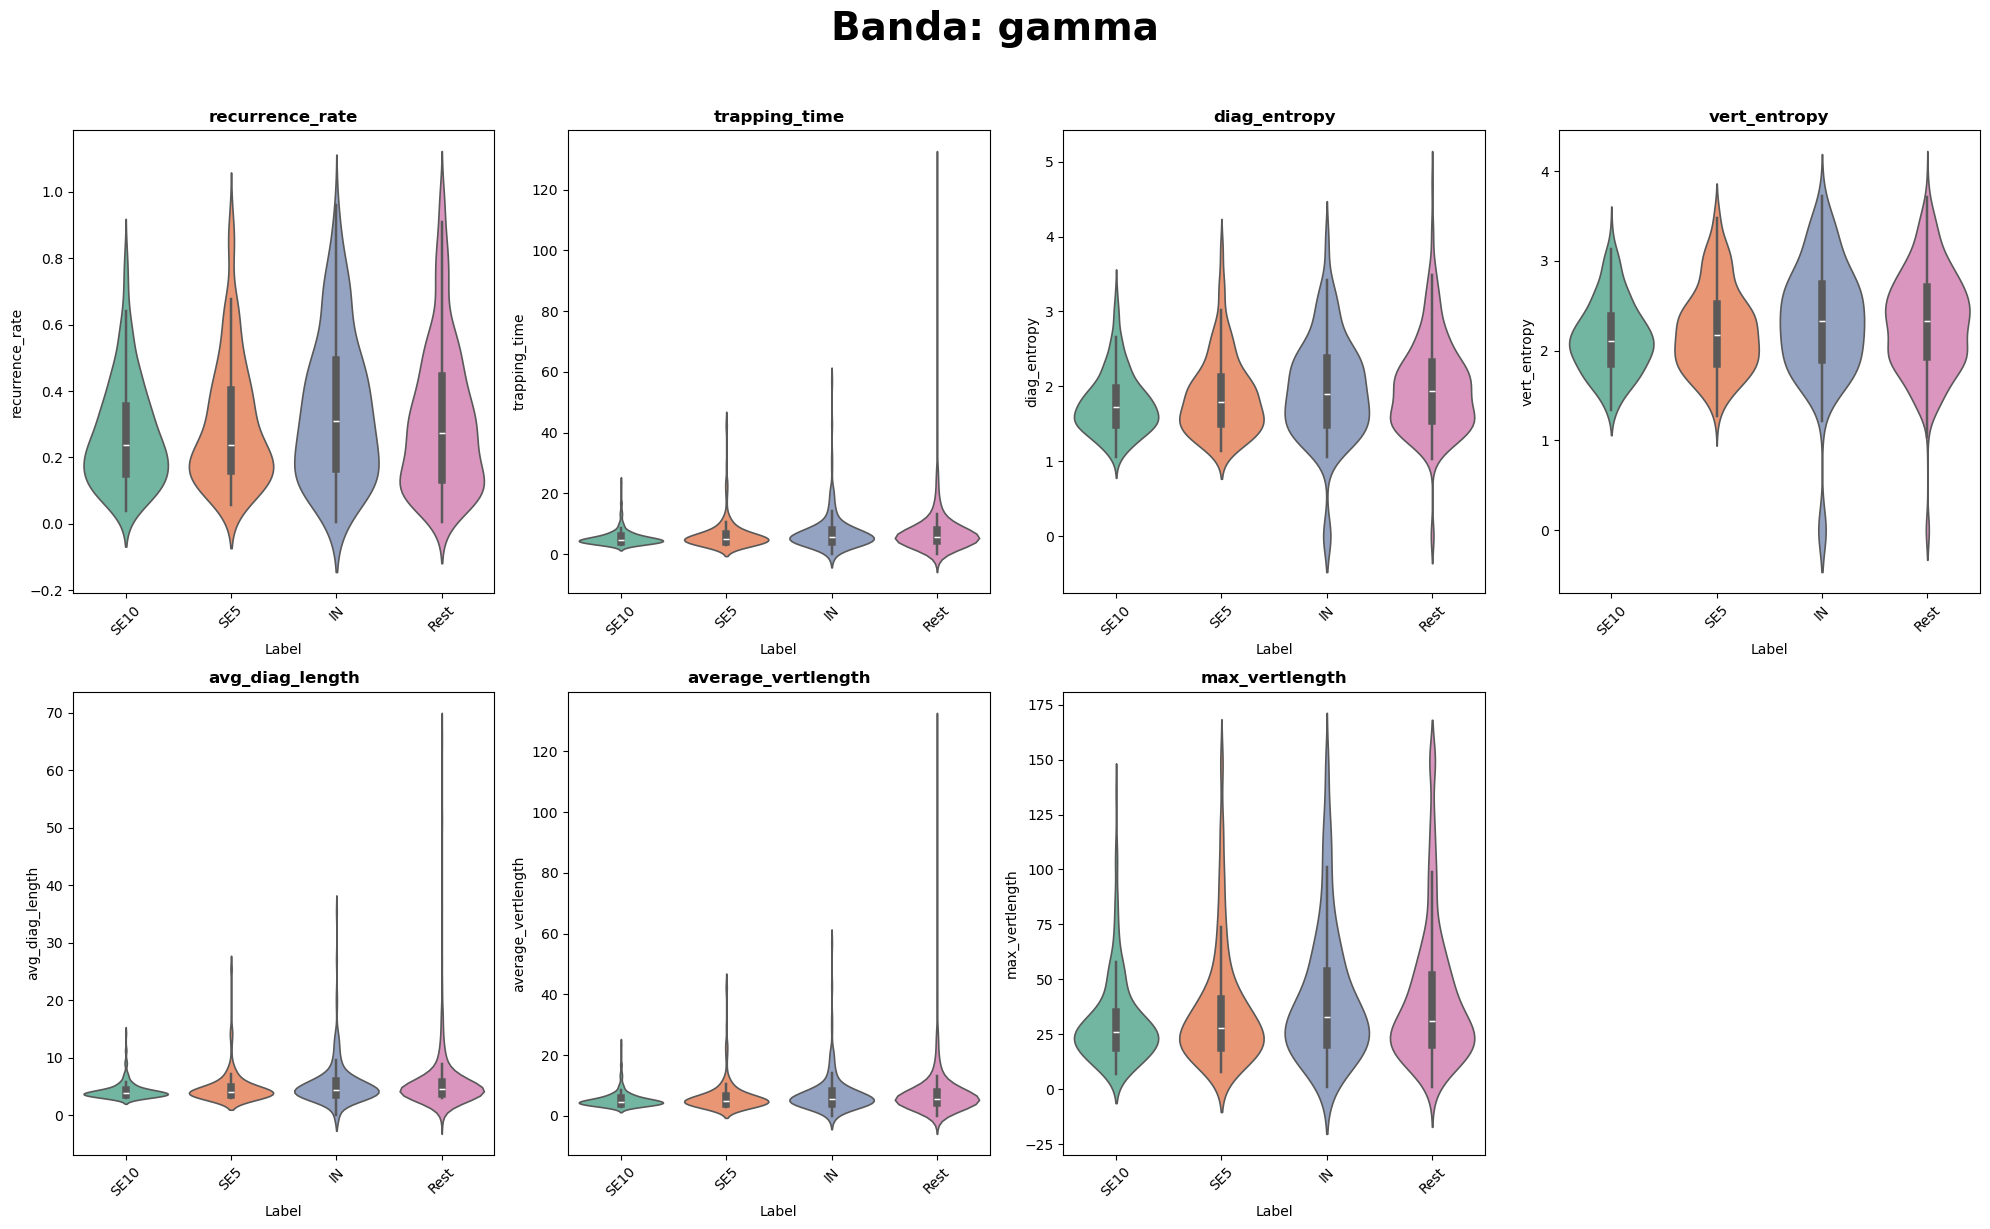

In [411]:
import seaborn as sns
import matplotlib.pyplot as plt

cols_to_plot = [col for col in significant_cols if col != 'label']

# Setup plot grid
num_cols = len(cols_to_plot)
ncols = 4
nrows = -(-num_cols // ncols)  # Ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 6 * nrows))
axes = axes.flatten()

# Set title for the entire figure
fig.suptitle(f'Banda: {band}', fontsize=28, y=1.02, weight='bold')

# Plot each violin plot
for i, col in enumerate(cols_to_plot):
    sns.violinplot(data=df, x='label', y=col, ax=axes[i], palette='Set2', linewidth=1.2, hue="label")
    axes[i].set_title(col, fontsize=12, fontweight='semibold')
    axes[i].set_xlabel("Label", fontsize=10)
    axes[i].set_ylabel(col, fontsize=10)
    axes[i].tick_params(axis='x', labelrotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout and spacing
plt.tight_layout()
fig.subplots_adjust(top=0.92)  # Leave space for suptitle

plt.show()
